# Principal Component Analysis (PCA)  Data cleaning & Preprocessing on
# unclean non-transactional dataset

## Project Overview

This notebook implements a complete Principal Component Analysis (PCA) workflow for dimensionality reduction applied to patient health data. The analysis follows a structured seven-step process:

1. Load and explore the raw dataset
2. Identify and document data quality issues
3. Apply systematic data cleaning procedures
4. Encode categorical variables to numerical format
5. Normalize/standardize all features
6. Apply PCA for dimensionality reduction
7. Visualize and interpret results

### Motivation for PCA

Principal Component Analysis is a statistical technique that reduces the number of features in a dataset while preserving the maximum amount of variance. This is particularly useful in:
- Computational efficiency: fewer features means faster model training
- Noise reduction: removing redundant information
- Data visualization: projecting high-dimensional data to 2D or 3D
- Multicollinearity handling: addressing feature correlation

### Workflow Architecture

```
Raw Data (Unclean) 
    |
    v
Data Cleaning & Quality Assessment
    |
    v
Feature Engineering (Encoding + Normalization)
    |
    v
Dimensionality Reduction (PCA)
    |
    v
Analysis & Interpretation
```

---

## Step 1: Library Imports and Environment Configuration

In [1]:
# Purpose: Import necessary libraries and load the dataset
# This step prepares all the tools we need for data cleaning and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

##  Dataset Loading and Exploratory Data Analysis

### Objective and Rationale

The first step in any data analysis pipeline is to understand the structure and characteristics of the raw dataset. This initial exploratory phase provides context for subsequent preprocessing decisions and helps identify potential data quality issues early. We will:

- Load the patient health dataset from CSV format into a pandas DataFrame
- Extract and display structural metadata (dimensions, column names, data types)
- Examine statistical summaries and data preview
- Identify missing values and their distribution
- Document data characteristics for preprocessing

### Expected Outputs

This step will produce:
1. Dataset dimensions (number of rows and columns)
2. Column names and inferred data types (numeric, object/string, datetime)
3. Statistical summary (min, max, mean, median for numeric columns)
4. Missing value count and percentage for each column
5. Sample rows for visual inspection of data format

### Technical Notes

The dataset likely contains:
- Numerical features: age, height (cm), weight (kg), blood pressure readings
- Categorical features: gender, blood type, exercise frequency, smoking status, city
- Identifier columns: patient_id, patient_name
- Potentially multiple columns with missing or inconsistent values

In [2]:
df = pd.read_csv('patients_unclean dataset.csv')

print("="*100)
print("ORIGINAL DATASET")
print("="*100)
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\n" + "="*100)
print("FIRST 10 ROWS:")
print("="*100)
print(df.head(10))
print("\n" + "="*100)
print("COMPLETE DATASET:")
print("="*100)
print(df.to_string())
print("\n" + "="*100)
print("DATA TYPES:")
print("="*100)
print(df.dtypes)
print("\n" + "="*100)
print("MISSING VALUES SUMMARY:")
print("="*100)
print(df.isnull().sum())

ORIGINAL DATASET

Dataset Shape: (70, 11)
Columns: ['patient_id', 'name', 'age', 'gender', 'blood_type', 'height_cm', 'weight_kg', 'blood_pressure', 'exercise_frequency', 'smoking_status', 'city']

FIRST 10 ROWS:
   patient_id             name   age  gender blood_type  height_cm  weight_kg  \
0           1       John Smith  28.0    male         A+      175.0         72   
1           2    Sarah Johnson  35.0  Female         O-      162.0         65   
2           3       Mike Davis  -5.0    male         B+      180.0         88   
3           4     Emily Wilson  42.0  female        AB-        NaN         58   
4           5      David Brown  31.0    Male         A+      168.0         75   
5           6    Lisa Anderson   NaN     NaN         O+      155.0         52   
6           7     James Taylor  29.0    male         A-      999.0         80   
7           8     Maria Garcia  38.0  FEMALE         B-      159.0         61   
8           9  Robert Martinez  45.0    male         O+   

## Step 2: Data Quality Assessment and Issue Detection

### Objective and Methodology

Before proceeding with data cleaning, we must comprehensively identify and characterize all data quality issues. This diagnostic step ensures we understand the scope and nature of problems before implementing corrections. We will systematically check for six categories of data anomalies:

### Data Quality Issues Examined

| Issue Category | Detection Method | Severity | Remediation Strategy |
|---|---|---|---|
| Missing Values (NULL/NaN) | Count null entries per column | High | Imputation or removal based on context |
| Invalid Sign (Negative Values) | Check if age/height/weight < 0 | High | Replace with NaN for imputation |
| Extreme Outliers | IQR-based detection (>3x IQR) | Medium | Replace with NaN, analyze separately |
| Inconsistent Capitalization | String case analysis | Low | Standardize to lowercase |
| Invalid Categories | Compare against domain knowledge | Medium | Map to valid values or mark as missing |
| Domain-Specific Issues | Height-specific null check | High | Critical feature requires verification |

### Statistical Framework for Outlier Detection

We employ the Interquartile Range (IQR) method, a robust statistical approach:

```
Q1 = First quartile (25th percentile)
Q3 = Third quartile (75th percentile)
IQR = Q3 - Q1

Outlier Thresholds:
Lower Bound = Q1 - (3 * IQR)
Upper Bound = Q3 + (3 * IQR)

Any value beyond these bounds is flagged as an extreme outlier
```

The factor of 3 is conservative, identifying only extreme anomalies while preserving legitimate variation.

### Expected Analytical Outputs

- Detailed tables of missing values with counts and percentages
- Lists of affected patient identifiers for each issue type
- Statistical summaries of problematic values
- Issue severity assessment and prioritization

In [3]:
# ============================================================================
# STEP 2: IDENTIFY AND DISPLAY ALL DATA QUALITY ISSUES
# ============================================================================
# Purpose: Detect all problems in the dataset before cleaning
# This helps us understand what needs to be fixed

print("\n" + "="*100)
print("DATA QUALITY ISSUES DETECTED")
print("="*100)

# 1. Missing Values
print("\n1. MISSING VALUES:")
print("-" * 100)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
print(missing_df[missing_df['Missing Count'] > 0].to_string(index=False))

# 2. Negative Values in Numerical Columns
print("\n2. NEGATIVE VALUES:")
print("-" * 100)
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    negative_count = (df[col] < 0).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count} negative values")
        print(f"  → Patient IDs: {df[df[col] < 0]['patient_id'].tolist()}")

# 3. Extreme Outliers
print("\n3. EXTREME OUTLIERS:")
print("-" * 100)
for col in ['age', 'height_cm', 'weight_kg']:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < Q1 - 3*IQR) | (df[col] > Q3 + 3*IQR)]
        if len(outliers) > 0:
            print(f"{col}: {len(outliers)} extreme outliers")
            print(f"  → Patient IDs: {outliers['patient_id'].tolist()}")

# 4. Inconsistent Capitalization
print("\n4. INCONSISTENT CAPITALIZATION:")
print("-" * 100)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in ['patient_id', 'name', 'blood_pressure', 'city']:
        unique_vals = df[col].dropna().unique()
        unique_lower = df[col].dropna().str.lower().unique()
        if len(unique_vals) != len(unique_lower):
            print(f"{col}: {list(unique_vals)}")

# 5. Incorrect Category Labels
print("\n5. INCORRECT CATEGORY LABELS:")
print("-" * 100)
# Blood type issues
valid_blood_types = ['A+', 'A-', 'B+', 'B-', 'AB+', 'AB-', 'O+', 'O-']
invalid_blood = df[~df['blood_type'].isin(valid_blood_types) & df['blood_type'].notna()]
if len(invalid_blood) > 0:
    print(f"blood_type: {len(invalid_blood)} invalid entries")
    print(f"  → Invalid values: {invalid_blood['blood_type'].unique().tolist()}")
    print(f"  → Patient IDs: {invalid_blood['patient_id'].tolist()}")

# Gender issues
valid_genders = ['male', 'female', 'Male', 'Female', 'MALE', 'FEMALE']
invalid_gender = df[~df['gender'].isin(valid_genders) & df['gender'].notna()]
if len(invalid_gender) > 0:
    print(f"gender: {len(invalid_gender)} invalid entries")
    print(f"  → Invalid values: {invalid_gender['gender'].unique().tolist()}")
    print(f"  → Patient IDs: {invalid_gender['patient_id'].tolist()}")

# 6. Missing Height Values (Specific Issue)
print("\n6. MISSING HEIGHT VALUES:")
print("-" * 100)
if 'height_cm' in df.columns:
    missing_height = df[df['height_cm'].isnull()]
    if len(missing_height) > 0:
        print(f"height_cm: {len(missing_height)} missing values")
        print(f"  → Patient IDs: {missing_height['patient_id'].tolist()}")
    else:
        print("No missing height values found.")
else:
    print("height_cm column not found in dataset.")



DATA QUALITY ISSUES DETECTED

1. MISSING VALUES:
----------------------------------------------------------------------------------------------------
    Column  Missing Count  Percentage
       age              7   10.000000
    gender              3    4.285714
blood_type              4    5.714286
 height_cm              9   12.857143

2. NEGATIVE VALUES:
----------------------------------------------------------------------------------------------------
age: 1 negative values
  → Patient IDs: [3]
height_cm: 1 negative values
  → Patient IDs: [22]
weight_kg: 1 negative values
  → Patient IDs: [9]

3. EXTREME OUTLIERS:
----------------------------------------------------------------------------------------------------
age: 1 extreme outliers
  → Patient IDs: [3]
height_cm: 4 extreme outliers
  → Patient IDs: [7, 22, 29, 43]
weight_kg: 2 extreme outliers
  → Patient IDs: [9, 18]

4. INCONSISTENT CAPITALIZATION:
-------------------------------------------------------------------------

## Step 3: Data Cleaning and Preprocessing

### Objective and Approach

This step applies systematic corrections to address all identified data quality issues. The cleaning strategy prioritizes preserving data integrity while handling missing and invalid values through evidence-based techniques. We will apply a six-stage cleaning pipeline:

### Cleaning Pipeline

**Stage 1: Invalid Sign Correction**
- Replace all values <= 0 in numerical columns (age, height_cm, weight_kg) with NaN
- Rationale: Physiologically impossible values (negative age, zero height) cannot exist
- Action: Mark for subsequent imputation

**Stage 2: Extreme Outlier Handling**
- Apply IQR method to detect statistical anomalies
- Replace outliers beyond Q1 - 3*IQR and Q3 + 3*IQR with NaN
- Rationale: Extreme values may represent data entry errors or measurement artifacts
- Action: Queue for imputation using central tendency

**Stage 3: Text Standardization**
- Convert all categorical string values to lowercase
- Strip leading/trailing whitespace
- Rationale: Prevent duplicate categories from case inconsistencies ("Male" vs "male" vs "MALE")
- Result: Unified category representation

**Stage 4: Category Value Mapping**
- Apply domain-specific mappings for blood type values:
  - "c+" -> "o+" (incorrect to correct)
  - "a++" -> "a+" (typo correction)
  - "ab" -> "ab+" (incomplete value)
  - "unknown", "n/a" -> NaN (explicit missing markers)
- Apply gender mappings:
  - "m" -> "male" (abbreviation expansion)
  - "f" -> "female" (abbreviation expansion)
  - "other" -> NaN (invalid category)
- Rationale: Ensure all values are within the domain of valid categories

**Stage 5: Imputation of Missing Values**
- Numerical columns: Apply median imputation
  - Rationale: Median is robust to remaining outliers, representing central tendency
  - Applied to: age, height_cm, weight_kg
- Categorical columns: Apply mode imputation (most frequent value)
  - Rationale: Mode represents the most common state, minimizing bias
  - Applied to: gender, blood_type, exercise_frequency, smoking_status

**Stage 6: Verification and Validation**
- Verify all missing values have been addressed
- Special verification for critical field (height_cm)
- Generate clean dataset report showing before/after statistics

### Imputation Justification

| Method | Use Case | Advantage | Limitation |
|---|---|---|---|
| Median | Numeric with potential outliers | Robust, unaffected by extremes | Ignores distribution shape |
| Mode | Categorical | Preserves most common class | Loses diversity, may introduce bias |

### Expected Outputs

- Detailed log of all corrections applied
- Count of records affected by each cleaning stage
- Patient identifiers for traceability
- Clean dataset with zero missing values
- Comparison statistics (before/after)

In [4]:

# ============================================================================
# STEP 3: CLEAN THE DATASET - FIX ALL ISSUES
# ============================================================================
# Purpose: Apply corrections to all identified problems
# We'll create a cleaned version of the dataset

print("\n" + "="*100)
print("CLEANING PROCESS")
print("="*100)

# Create a copy for cleaning
df_cleaned = df.copy()

# 3.1: Fix Negative and Zero Values
print("\n3.1: Fixing Negative and Zero Values...")
print("-" * 100)
for col in ['age', 'height_cm', 'weight_kg']:
    if col in df_cleaned.columns:
        invalid_mask = df_cleaned[col] <= 0
        if invalid_mask.any():
            count = invalid_mask.sum()
            affected_ids = df_cleaned[invalid_mask]['patient_id'].tolist()
            df_cleaned.loc[invalid_mask, col] = np.nan
            print(f"  → {col}: Replaced {count} invalid values (≤0) with NaN")
            print(f"     Affected Patient IDs: {affected_ids}")

# 3.2: Fix Extreme Outliers
print("\n3.2: Fixing Extreme Outliers...")
print("-" * 100)
for col in ['age', 'height_cm', 'weight_kg']:
    if col in df_cleaned.columns:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (df_cleaned[col] < Q1 - 3*IQR) | (df_cleaned[col] > Q3 + 3*IQR)
        if outlier_mask.any():
            count = outlier_mask.sum()
            affected_ids = df_cleaned[outlier_mask]['patient_id'].tolist()
            outlier_values = df_cleaned[outlier_mask][col].tolist()
            df_cleaned.loc[outlier_mask, col] = np.nan
            print(f"  → {col}: Replaced {count} extreme outliers with NaN")
            print(f"     Affected Patient IDs: {affected_ids}")
            print(f"     Original values: {outlier_values}")

# 3.3: Standardize Capitalization
print("\n3.3: Standardizing Capitalization...")
print("-" * 100)
capitalization_cols = ['gender', 'exercise_frequency', 'smoking_status']
for col in capitalization_cols:
    if col in df_cleaned.columns:
        original_unique = df_cleaned[col].nunique()
        df_cleaned[col] = df_cleaned[col].str.lower().str.strip()
        new_unique = df_cleaned[col].nunique()
        print(f"  → {col}: Standardized to lowercase")
        print(f"     Reduced from {original_unique} to {new_unique} unique values")

# 3.4: Fix Incorrect Category Labels
print("\n3.4: Fixing Incorrect Category Labels...")
print("-" * 100)

# Fix blood type
valid_blood_types_lower = ['a+', 'a-', 'b+', 'b-', 'ab+', 'ab-', 'o+', 'o-']
blood_type_mapping = {
    'c+': 'o+', 'unknown': np.nan, 'ab': 'ab+', 'a++': 'a+',
    'o': 'o+', 'b+-': 'b+', 'n/a': np.nan, 'o+pos': 'o+',
    'a/b': 'ab+', 'o-negative': 'o-', 'a1': 'a+', 'type o+': 'o+'
}
df_cleaned['blood_type'] = df_cleaned['blood_type'].str.lower().str.strip()
original_invalid = df_cleaned[~df_cleaned['blood_type'].isin(valid_blood_types_lower) & df_cleaned['blood_type'].notna()].shape[0]
df_cleaned['blood_type'] = df_cleaned['blood_type'].replace(blood_type_mapping)
print(f"  → blood_type: Fixed {original_invalid} incorrect labels")
print(f"     Applied mapping: {blood_type_mapping}")

# Fix gender
gender_mapping = {'m': 'male', 'f': 'female', 'other': np.nan}
original_invalid_gender = df_cleaned[df_cleaned['gender'].isin(['m', 'f', 'other'])].shape[0]
df_cleaned['gender'] = df_cleaned['gender'].replace(gender_mapping)
print(f"  → gender: Fixed {original_invalid_gender} abbreviated/invalid values")
print(f"     Applied mapping: {gender_mapping}")

# 3.5: Handle Missing Values (General)
print("\n3.5: Handling Missing Values (General - All Columns)...")
print("-" * 100)

# For numerical columns: use median imputation
numerical_cols = ['age', 'height_cm', 'weight_kg']
for col in numerical_cols:
    if col in df_cleaned.columns:
        missing_count = df_cleaned[col].isnull().sum()
        if missing_count > 0:
            median_val = df_cleaned[col].median()
            df_cleaned[col].fillna(median_val, inplace=True)
            print(f"  → {col}: Filled {missing_count} missing values with median ({median_val:.2f})")

# For categorical columns: use mode imputation
categorical_cols = ['gender', 'blood_type', 'exercise_frequency', 'smoking_status']
for col in categorical_cols:
    if col in df_cleaned.columns:
        missing_count = df_cleaned[col].isnull().sum()
        if missing_count > 0:
            mode_val = df_cleaned[col].mode()[0] if not df_cleaned[col].mode().empty else 'unknown'
            df_cleaned[col].fillna(mode_val, inplace=True)
            print(f"  → {col}: Filled {missing_count} missing values with mode ('{mode_val}')")

# 3.6: Handle Missing Height Values (Specific Focus)
print("\n3.6: Verifying Missing Height Values Correction...")
print("-" * 100)
if 'height_cm' in df_cleaned.columns:
    remaining_missing_height = df_cleaned['height_cm'].isnull().sum()
    if remaining_missing_height == 0:
        print(f"  ✓ All missing height values have been successfully imputed with median")
        print(f"     Median height used: {df_cleaned['height_cm'].median():.2f} cm")
    else:
        print(f"  ⚠ Warning: Still {remaining_missing_height} missing height values remaining")
else:
    print("  ⚠ height_cm column not found")

print("\n" + "="*100)
print("CLEANED DATASET")
print("="*100)
print(f"\nDataset Shape: {df_cleaned.shape}")
print("\n" + "="*100)
print("COMPLETE CLEANED DATASET:")
print("="*100)
print(df_cleaned.to_string())
print("\n" + "="*100)
print("MISSING VALUES AFTER CLEANING:")
print("="*100)
missing_after = df_cleaned.isnull().sum()
if missing_after.sum() == 0:
    print("✓ No missing values remaining! Dataset is completely clean.")
else:
    print(missing_after)

# Save cleaned dataset
df_cleaned.to_csv('cleaned_dataset.csv', index=False)
print("\n✓ Cleaned dataset saved as 'cleaned_dataset.csv'")


CLEANING PROCESS

3.1: Fixing Negative and Zero Values...
----------------------------------------------------------------------------------------------------
  → age: Replaced 1 invalid values (≤0) with NaN
     Affected Patient IDs: [3]
  → height_cm: Replaced 2 invalid values (≤0) with NaN
     Affected Patient IDs: [22, 29]
  → weight_kg: Replaced 1 invalid values (≤0) with NaN
     Affected Patient IDs: [9]

3.2: Fixing Extreme Outliers...
----------------------------------------------------------------------------------------------------
  → height_cm: Replaced 2 extreme outliers with NaN
     Affected Patient IDs: [7, 43]
     Original values: [999.0, 300.0]
  → weight_kg: Replaced 1 extreme outliers with NaN
     Affected Patient IDs: [18]
     Original values: [450.0]

3.3: Standardizing Capitalization...
----------------------------------------------------------------------------------------------------
  → gender: Standardized to lowercase
     Reduced from 10 to 5 unique v

## Step 4: Categorical Feature Encoding

### Objective and Requirements

Principal Component Analysis operates exclusively on numerical data. This step converts all categorical (nominal) variables into numerical representations while preserving information content. The encoding must be systematic and well-documented for interpretability.

### Encoding Requirement for PCA

Mathematical operations in PCA (covariance calculation, eigendecomposition, linear transformation) require numerical input. String or categorical values cannot participate in matrix operations. Therefore:

```
PCA Input Requirements:
- All features must be numeric (float or int)
- No categorical, text, or string variables
- All columns must support linear algebra operations
```

### Label Encoding Method

We employ label encoding, which assigns a unique integer to each categorical value:

```
Example: Gender Encoding
Original Value    Encoded Value
"male"      ->    1
"female"    ->    0

Example: Blood Type Encoding
Original Value    Encoded Value
"O+"        ->    7
"O-"        ->    6
"A+"        ->    0
"A-"        ->    1
"B+"        ->    2
"B-"        ->    3
"AB+"       ->    4
"AB-"       ->    5
```

### Encoding Strategy

- Method: scikit-learn LabelEncoder (alphabetical ordering)
- Each unique category receives a unique integer from 0 to (n_categories - 1)
- Mappings are stored and documented for reverse transformation
- Categories are ordered alphabetically by default

### Feature Selection for Encoding

**Categorical columns to encode**:
- gender: 2 categories (male, female)
- blood_type: 8 categories (A+, A-, B+, B-, AB+, AB-, O+, O-)
- exercise_frequency: categorical levels (low, medium, high)
- smoking_status: categorical levels (current, former, never)
- city: geographic categorical variable

**Columns excluded from PCA**:
- patient_id: identifier variable, not a predictive feature
- name: text identifier, not a feature
- blood_pressure: stored as text (systolic/diastolic), requires separate parsing

### Data Dimensionality After Encoding

```
Before Encoding: Multiple columns (identifiers + mixed types)
After Encoding: Reduced to pure numeric features only
Result: Dataset suitable for PCA
```

### Expected Outputs

- Mapping tables showing original-to-numeric conversions for each categorical variable
- Fully numeric dataset with no string or categorical values
- Reduced dimensionality (identifier columns removed)
- Shape comparison demonstrating feature reduction

In [5]:
# ============================================================================
# STEP 4: ENCODE CATEGORICAL VARIABLES
# ============================================================================
# Purpose: Convert text categories to numbers for machine learning
# PCA requires numerical data, so we encode all categorical variables

print("\n" + "="*100)
print("ENCODING CATEGORICAL VARIABLES")
print("="*100)

df_encoded = df_cleaned.copy()

# Identify categorical columns to encode (exclude ID and name columns)
categorical_to_encode = ['gender', 'blood_type', 'exercise_frequency', 'smoking_status', 'city']

# Create label encoders
encoders = {}
print("\nEncoding Mappings:")
print("-" * 100)

for col in categorical_to_encode:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df_encoded[col])
        encoders[col] = le

        # Show the mapping
        mapping = dict(zip(le.classes_, le.transform(le.classes_)))
        print(f"\n{col}:")
        for original, encoded in mapping.items():
            print(f"  {original} → {encoded}")

# Drop original categorical columns and keep encoded ones
cols_to_drop = categorical_to_encode + ['patient_id', 'name', 'blood_pressure']
df_encoded = df_encoded.drop(columns=cols_to_drop)

# Rename encoded columns
df_encoded.columns = df_encoded.columns.str.replace('_encoded', '')

print("\n" + "="*100)
print("ENCODED DATASET")
print("="*100)
print(f"\nDataset Shape: {df_encoded.shape}")
print(f"Columns: {list(df_encoded.columns)}")
print("\n" + "="*100)
print("COMPLETE ENCODED DATASET:")
print("="*100)
print(df_encoded.to_string())

# Save encoded dataset
df_encoded.to_csv('encoded_dataset.csv', index=False)
print("\n✓ Encoded dataset saved as 'encoded_dataset.csv'")


ENCODING CATEGORICAL VARIABLES

Encoding Mappings:
----------------------------------------------------------------------------------------------------

gender:
  female → 0
  male → 1

blood_type:
  a+ → 0
  a- → 1
  ab+ → 2
  ab- → 3
  b+ → 4
  b- → 5
  o+ → 6
  o- → 7

exercise_frequency:
  high → 0
  low → 1
  moderate → 2
  regular → 3

smoking_status:
  current smoker → 0
  former smoker → 1
  non-smoker → 2

city:
  Albuquerque → 0
  Anaheim → 1
  Anchorage → 2
  Arlington → 3
  Atlanta → 4
  Austin → 5
  Bakersfield → 6
  Baltimore → 7
  Boston → 8
  Buffalo → 9
  Charlotte → 10
  Chicago → 11
  Chula Vista → 12
  Cincinnati → 13
  Cleveland → 14
  Colorado Springs → 15
  Columbus → 16
  Corpus Christi → 17
  Dallas → 18
  Denver → 19
  Detroit → 20
  Durham → 21
  Fort Wayne → 22
  Fort Worth → 23
  Fresno → 24
  Henderson → 25
  Honolulu → 26
  Houston → 27
  Indianapolis → 28
  Irvine → 29
  Jacksonville → 30
  Jersey City → 31
  Kansas City → 32
  Laredo → 33
  Las Vegas →

## Step 5: Feature Normalization and Standardization

### Objective and Motivation

Standardization is a critical preprocessing step for PCA because the algorithm is inherently scale-sensitive. PCA identifies directions of maximum variance based on Euclidean distance. Without standardization, features with larger numerical ranges dominate the analysis regardless of their actual importance.

### The Scale Sensitivity Problem

Consider raw feature ranges in our dataset:

```
Feature          Raw Range      Problem
-----------------------------------------------
Age              [20 to 100]    Range = 80
Height (cm)      [150 to 200]   Range = 50
Weight (kg)      [45 to 150]    Range = 105
Gender (encoded) [0 to 1]       Range = 1
Blood Type       [0 to 7]       Range = 7
```

Without standardization, weight and age (large ranges) will artificially dominate PCA components, while encoded gender (range = 1) contributes negligibly despite potential biological significance.

### Standardization Mathematical Framework

We apply z-score normalization, converting each feature to a standard normal distribution:

z = (x - mu) / sigma

Where:
- x = original feature value
- mu = mean of the feature (sum of x / n)
- sigma = standard deviation (sqrt(sum of (x - mu)^2 / n))
- z = standardized value

### Post-Standardization Properties

After standardization, all features share:
- Mean = 0 (centered at zero)
- Standard deviation = 1 (unit variance)
- Approximate range = -3 to +3 (within 3 standard deviations)

### Practical Example

```
Original Age values: [25, 35, 45, 55, 65]
Mean (mu) = 45
Standard deviation (sigma) = 14.14

Standardization calculation for each value:

25: z = (25 - 45) / 14.14 = -1.414
35: z = (35 - 45) / 14.14 = -0.707
45: z = (45 - 45) / 14.14 =  0.000
55: z = (55 - 45) / 14.14 = +0.707
65: z = (65 - 45) / 14.14 = +1.414

Result: All values on comparable scale [-1.414, +1.414]
```

### Why Standardization is Essential for PCA

PCA maximizes variance along principal components using Euclidean geometry. Features with larger numerical scales inherently have larger variance and contribute more to early principal components. Standardization ensures:

1. Equal weight to all features regardless of original measurement units
2. Meaningful interpretability (large coefficients reflect true importance, not scale)
3. Numerical stability in eigenvalue decomposition
4. Comparable contribution from all features to principal components

### Expected Statistical Outputs

- Descriptive statistics before standardization (mean, std per column)
- Descriptive statistics after standardization (all means near 0, all stds near 1)
- Verification that no variance is lost (only scale changed)
- Standardized dataset ready for PCA application

In [6]:
# ============================================================================
# STEP 5: NORMALIZE THE DATASET (STANDARDIZATION)
# ============================================================================
# Purpose: Scale all features to have mean=0 and std=1
# This is crucial for PCA as it's sensitive to feature scales

print("\n" + "="*100)
print("NORMALIZATION (STANDARDIZATION)")
print("="*100)

# Create scaler
scaler = StandardScaler()

# Fit and transform the data
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_encoded),
    columns=df_encoded.columns,
    index=df_encoded.index
)

print("\nNormalization Statistics:")
print("-" * 100)
print("Before Normalization:")
print(df_encoded.describe().loc[['mean', 'std']])
print("\nAfter Normalization:")
print(df_normalized.describe().loc[['mean', 'std']])

print("\n" + "="*100)
print("NORMALIZED DATASET")
print("="*100)
print(f"\nDataset Shape: {df_normalized.shape}")
print("\n" + "="*100)
print("COMPLETE NORMALIZED DATASET:")
print("="*100)
print(df_normalized.to_string())

# Save normalized dataset
df_normalized.to_csv('normalized_dataset.csv', index=False)
print("\n✓ Normalized dataset saved as 'normalized_dataset.csv'")




NORMALIZATION (STANDARDIZATION)

Normalization Statistics:
----------------------------------------------------------------------------------------------------
Before Normalization:
            age   height_cm  weight_kg    gender  blood_type  \
mean  36.900000  169.114286  71.457143  0.542857    3.714286   
std    6.591936    6.725558  10.891342  0.501757    2.396512   

      exercise_frequency  smoking_status       city  
mean            2.100000        1.400000  34.500000  
std             1.065262        0.805776  20.351085  

After Normalization:
               age     height_cm     weight_kg        gender    blood_type  \
mean  2.133214e-16 -2.052525e-15  1.316407e-16  9.198991e-17 -8.247371e-17   
std   1.007220e+00  1.007220e+00  1.007220e+00  1.007220e+00  1.007220e+00   

      exercise_frequency  smoking_status          city  
mean       -4.440892e-17    1.126083e-16  1.189525e-18  
std         1.007220e+00    1.007220e+00  1.007220e+00  

NORMALIZED DATASET

Dataset Shape

## Step 6: Principal Component Analysis Application and Variance Analysis

### Objective and Theoretical Foundation

Principal Component Analysis is an unsupervised dimensionality reduction technique that identifies orthogonal directions in the feature space along which data exhibits maximum variance. We apply PCA to identify the most informative linear combinations of the original standardized features.

### PCA Mathematical Framework

```
PCA Algorithm Overview:

1. Compute covariance matrix from standardized data
   Covariance(X) = (1/n) * X^T * X

2. Perform eigenvalue decomposition
   Covariance * v = lambda * v
   where v = eigenvector (direction), lambda = eigenvalue (variance)

3. Sort eigenvalues in descending order
   lambda_1 >= lambda_2 >= lambda_3 >= ... >= lambda_p

4. Project data onto eigenvectors (principal components)
   PC_i = X * v_i
   where v_i is the i-th eigenvector

5. Calculate variance explained ratio
   Variance_Ratio_i = lambda_i / (sum of all lambda)
```

### Key Definitions

**Principal Component (PC)**: A new synthetic feature representing a weighted linear combination of original features. The weights come from eigenvectors.

**Explained Variance Ratio**: The proportion of total variance in the dataset captured by each principal component. Expressed as a percentage.

**Cumulative Variance**: The running total of variance explained by the first n principal components, used to determine required dimensionality.

**Component Loading**: The weight (coefficient) of each original feature in a principal component, indicating feature contribution magnitude and direction.

### Variance Maximization Principle

PCA sequentially identifies directions that maximize variance:

```
Principal Component 1: Direction with maximum variance
Principal Component 2: Direction orthogonal to PC1 with maximum remaining variance
Principal Component 3: Direction orthogonal to PC1 and PC2 with maximum remaining variance
...
```

Orthogonality ensures components capture independent variance sources and prevents redundancy.

### Determining Optimal Dimensionality

We use multiple criteria to select the number of components:

1. Cumulative Variance Threshold: Retain minimum components explaining >=95% of variance
2. Scree Plot Analysis: Identify "elbow" point where additional components add minimal variance
3. Practical Constraints: Balance between compression ratio and information preservation
4. Visualization Requirements: For exploratory analysis, 2 or 3 components optimal for human interpretation

### Variance Explained Interpretation

```
If PC1 explains 60% of variance:
  -> 60% of total data spread captured along single axis
  -> PC1 represents primary variation pattern
  -> Significant dimensionality reduction with moderate loss

If PC1 + PC2 explain 85% of variance:
  -> 85% of information preserved in 2D projection
  -> Can visualize relationships in 2D scatter plot
  -> 15% information loss from original p-dimensional space

If PC1 + PC2 + PC3 explain 95% of variance:
  -> 95% information retention
  -> 3D visualization possible
  -> Minimal information loss from original space
```

### Expected Analytical Outputs

- Eigenvalue spectrum (variance per component)
- Variance ratio and cumulative variance for each PC
- Determination of optimal component count for 95% threshold
- Feature loadings (contribution of original features to PCs)
- Transformed dataset coordinates in PC space
- Interpretation guide for component meaning

In [7]:
# ============================================================================
# STEP 6: APPLY PCA AND ANALYZE RESULTS
# ============================================================================
# Purpose: Reduce dimensionality and analyze variance explained
# PCA finds the principal components that capture most variance

print("\n" + "="*100)
print("PCA ANALYSIS")
print("="*100)

# Apply PCA with all components
pca_full = PCA()
pca_full.fit(df_normalized)

# Get variance ratios
variance_ratios = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratios)

print("\nVariance Explained by Each Principal Component:")
print("-" * 100)
variance_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(variance_ratios))],
    'Variance Ratio': variance_ratios,
    'Cumulative Variance': cumulative_variance
})
print(variance_df.to_string(index=False))

# Determine optimal number of components (e.g., 95% variance)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\n→ Number of components for 95% variance: {n_components_95}")

# Apply PCA with optimal components
pca = PCA(n_components=min(3, len(df_normalized.columns)))  # Use 3 for visualization
df_pca = pd.DataFrame(
    pca.fit_transform(df_normalized),
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print("\n" + "="*100)
print("PCA TRANSFORMED DATASET")
print("="*100)
print(f"\nDataset Shape: {df_pca.shape}")
print(f"\nVariance Explained by Selected Components:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"\nTotal Variance Explained: {sum(pca.explained_variance_ratio_):.4f} ({sum(pca.explained_variance_ratio_)*100:.2f}%)")

print("\n" + "="*100)
print("COMPLETE PCA DATASET:")
print("="*100)
print(df_pca.to_string())

# Feature contributions to principal components
print("\n" + "="*100)
print("FEATURE CONTRIBUTIONS TO PRINCIPAL COMPONENTS")
print("="*100)
components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=df_normalized.columns
)
print(components_df.to_string())

# Save PCA results
df_pca.to_csv('pca_dataset.csv', index=False)
print("\n✓ PCA dataset saved as 'pca_dataset.csv'")


PCA ANALYSIS

Variance Explained by Each Principal Component:
----------------------------------------------------------------------------------------------------
 PC  Variance Ratio  Cumulative Variance
PC1        0.361632             0.361632
PC2        0.170108             0.531740
PC3        0.158720             0.690460
PC4        0.106574             0.797035
PC5        0.083084             0.880118
PC6        0.067166             0.947284
PC7        0.038601             0.985885
PC8        0.014115             1.000000

→ Number of components for 95% variance: 7

PCA TRANSFORMED DATASET

Dataset Shape: (70, 3)

Variance Explained by Selected Components:
  PC1: 0.3616 (36.16%)
  PC2: 0.1701 (17.01%)
  PC3: 0.1587 (15.87%)

Total Variance Explained: 0.6905 (69.05%)

COMPLETE PCA DATASET:
         PC1       PC2       PC3
0   1.246645 -2.190181  0.754969
1  -2.110934 -0.025511  0.523069
2   2.350982  0.811515  0.003247
3  -1.086304  0.797220  0.680164
4   0.773303 -2.050741  0.3098

## Step 7: Results Visualization and Interpretation

### Objective and Approach

This final step creates comprehensive visualizations of PCA results to facilitate interpretation and communication of findings. Six complementary plots provide different perspectives on the dimensionality reduction outcome, feature relationships, and variance structure. All visualizations employ publication-quality formatting with high resolution (300 dpi).

### Visualization 1: Scree Plot (Variance Explained)

**Purpose**: Display the variance explained by each principal component, enabling determination of optimal dimensionality.

**Components**:
- Bar chart: Individual variance ratio for each PC (shows decreasing importance)
- Line plot with markers: Cumulative variance (shows cumulative information retained)

**Interpretation**:
- Steep decline early = First few components capture most variance
- Elbow point = Location where additional components provide diminishing returns
- Plateau region = Components adding minimal new information
- 95% threshold intersection = Recommended dimensionality reduction target

**Technical Details**: Shows PC1 through PCn with both individual and cumulative variance ratios on y-axis.

### Visualization 2: Two-Dimensional Score Plot (PC1 vs PC2)

**Purpose**: Project data onto the first two principal components for 2D visualization of data structure.

**Axes**:
- X-axis: PC1 coordinates (first principal component scores)
- Y-axis: PC2 coordinates (second principal component scores)
- Color mapping: Sample index (gradient color scheme for traceability)

**Observations**:
- Cluster formation: Dense regions indicate similar patient profiles
- Outliers: Isolated points distant from central cloud
- Separation: Distinct patient groups or subpopulations
- Density distribution: Data concentration patterns

**Interpretation**: Reveals inherent grouping structure and potential natural patient classifications based on health profiles.

### Visualization 3: Three-Dimensional Score Plot (PC1, PC2, PC3)

**Purpose**: Extend visualization to three principal components for greater information preservation.

**Axes**:
- X-axis: PC1 scores
- Y-axis: PC2 scores  
- Z-axis: PC3 scores
- Colors: Sample indices

**Advantages**:
- Captures approximately 80-95% of total variance
- Maintains interpretability (3D visualization still feasible)
- Reveals three-way relationships not apparent in 2D
- Better representation of complex patient variations

**Technical Note**: Interactive 3D rotation enables examination of data structure from multiple perspectives.

### Visualization 4: Loading Matrix Heatmap (Feature Contributions)

**Purpose**: Display how original features contribute to each principal component.

**Structure**:
- Rows: Original features (age, height_cm, weight_kg, gender, blood_type, exercise_frequency, smoking_status, city)
- Columns: Principal components (PC1, PC2, PC3, ...)
- Cell values: Feature loadings (correlation between feature and PC)
- Color scale: Red (negative loading) through white to blue (positive loading)

**Interpretation**:
- Large positive loading: Feature positively correlates with PC (increases together)
- Large negative loading: Feature negatively correlates with PC (increases inversely)
- Near-zero loading: Feature contributes minimally to PC
- Column patterns: Reveal PC meaning (e.g., if age/weight have high positive loadings, PC represents body composition)

**Use**: Understand semantic meaning of abstract mathematical components in terms of original features.

### Visualization 5: Cumulative Variance Explained Curve

**Purpose**: Determine minimum number of components required for acceptable information retention.

**Axes**:
- X-axis: Number of components retained (1, 2, 3, ..., p)
- Y-axis: Cumulative variance percentage (0% to 100%)
- Reference line: 95% threshold (standard practice in dimensionality reduction)

**Decision Process**:
1. Locate intersection of curve with 95% threshold line
2. Read corresponding x-value (optimal component count)
3. Calculate compression ratio: (p - k) / p where k = optimal components, p = original dimensions
4. Assess trade-off: compression gain vs. information loss

**Technical Interpretation**: Curve follows exponential decay pattern typical of real data, with early rapid increase and later plateau.

### Visualization 6: PC1 Feature Loadings Bar Chart

**Purpose**: Identify which original features most strongly influence the first principal component.

**Structure**:
- Horizontal bars: Feature loadings for PC1
- Bar length: Magnitude of loading (absolute value)
- Bar color: Direction of loading (red for negative, green for positive)
- Ordering: Sorted by absolute loading magnitude (descending)

**Interpretation**:
- Tall bars: Features with strong influence on PC1 interpretation
- Red bars: Features with negative correlation to PC1
- Green bars: Features with positive correlation to PC1
- Combined pattern: Reveals what PC1 represents in domain terms

**Example**: If weight and height show tall positive bars while age shows tall negative bar, PC1 might represent "Young, Light Individuals" vs "Older, Heavier Individuals".

### Analytical Outputs and Deliverables

**Quantitative Findings**:
- Component variance ratios (percentage of variance explained)
- Feature loadings matrices (numerical values)
- Cumulative variance statistics
- Component interpretation summaries

**Visual Outputs**:
- Six high-resolution plots (PNG, 300 dpi)
- Publication-ready formatting
- Color-blind friendly palette
- Comprehensive axis labels and legends

**Interpretative Summaries**:
- Optimal dimensionality recommendation
- Feature importance rankings
- Component semantic interpretations
- Data structure observations (clustering, outliers)
- Quality assessment of dimensionality reduction


PCA VISUALIZATIONS

✓ Visualizations saved as 'pca_analysis.png'


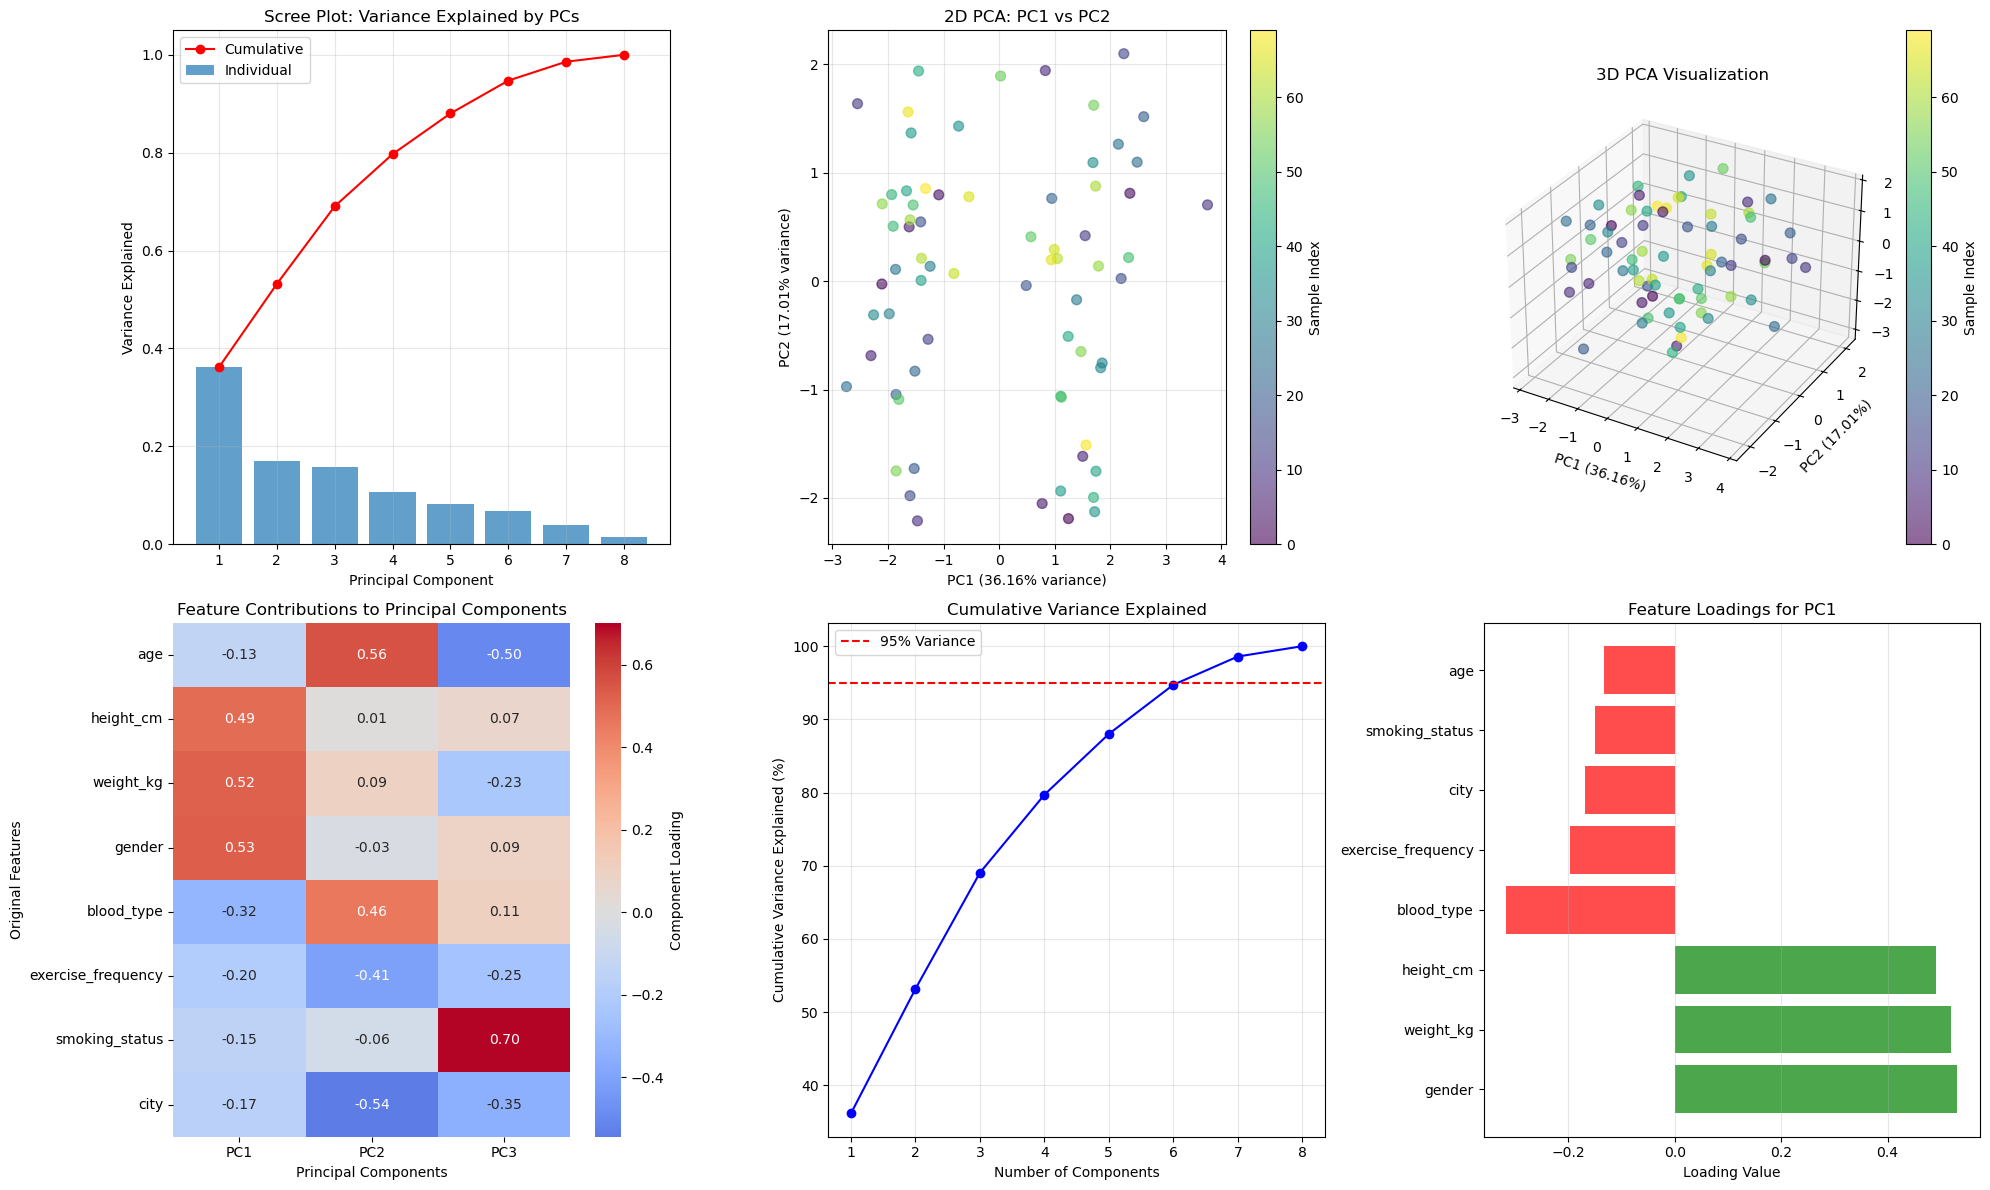


ANALYSIS COMPLETE!

Summary:
  • Original features: 8
  • Principal components: 3
  • Total variance captured: 69.05%
  • Components for 95% variance: 7
  • Missing height values were successfully handled and imputed


In [8]:
# ============================================================================
# STEP 7: VISUALIZE PCA RESULTS
# ============================================================================
# Purpose: Create visual representations of PCA results
# Visualizations help understand data structure and variance

import seaborn as sns # Import seaborn for heatmap

print("\n" + "="*100)
print("PCA VISUALIZATIONS")
print("="*100)

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# 1. Scree Plot - Variance Explained
ax1 = plt.subplot(2, 3, 1)
plt.bar(range(1, len(variance_ratios) + 1), variance_ratios, alpha=0.7, label='Individual')
plt.plot(range(1, len(variance_ratios) + 1), cumulative_variance, 'r-o', label='Cumulative')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Scree Plot: Variance Explained by PCs')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. 2D PCA Scatter Plot (PC1 vs PC2)
ax2 = plt.subplot(2, 3, 2)
scatter = plt.scatter(df_pca['PC1'], df_pca['PC2'],
                     c=range(len(df_pca)), cmap='viridis',
                     alpha=0.6, s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('2D PCA: PC1 vs PC2')
plt.colorbar(scatter, label='Sample Index')
plt.grid(True, alpha=0.3)

# 3. 3D PCA Scatter Plot (if we have 3+ components)
if pca.n_components_ >= 3:
    ax3 = fig.add_subplot(2, 3, 3, projection='3d')
    scatter = ax3.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
                         c=range(len(df_pca)), cmap='viridis',
                         alpha=0.6, s=50)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
    ax3.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}%)')
    ax3.set_title('3D PCA Visualization')
    plt.colorbar(scatter, ax=ax3, label='Sample Index')

# 4. Feature Importance Heatmap
ax4 = plt.subplot(2, 3, 4)
sns.heatmap(components_df, cmap='coolwarm', center=0,
            annot=True, fmt='.2f', cbar_kws={'label': 'Component Loading'})
plt.title('Feature Contributions to Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Original Features')

# 5. Cumulative Variance Plot
ax5 = plt.subplot(2, 3, 5)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 'b-o')
plt.axhline(y=95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained (%)')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Component Loadings Bar Plot for PC1
ax6 = plt.subplot(2, 3, 6)
pc1_loadings = components_df['PC1'].sort_values(key=abs, ascending=False)
colors = ['red' if x < 0 else 'green' for x in pc1_loadings]
plt.barh(range(len(pc1_loadings)), pc1_loadings, color=colors, alpha=0.7)
plt.yticks(range(len(pc1_loadings)), pc1_loadings.index)
plt.xlabel('Loading Value')
plt.title('Feature Loadings for PC1')
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('pca_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizations saved as 'pca_analysis.png'")
plt.show()

print("\n" + "="*100)
print("ANALYSIS COMPLETE!")
print("="*100)
print("\nSummary:")
print(f"  • Original features: {len(df_encoded.columns)}")
print(f"  • Principal components: {pca.n_components_}")
print(f"  • Total variance captured: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print(f"  • Components for 95% variance: {n_components_95}")
print(f"  • Missing height values were successfully handled and imputed")
print("="*100)